The source of our data is ["On the Use of Discriminant Functions in Taxonomy"](https://www.jstor.org/stable/2527894?seq=1#page_scan_tab_contents) by Alexander A. Lubischew. The dataset contains physical measures of on three species of flea beetles. The features are:

* species - One of concinna, heptapotamica or heikertingeri
* tars1 - width of the first joint of the first tarsus in microns
* tars2 - width of the second joint of the first tarsus in microns
* head - the maximal width of the head between the external edges of the eyes in 0.01 mm
* aede1 - the maximal width of the aedeagus in the fore-part in microns
* aede2 - the front angle of the aedeagus (1 unit = 7.5 degrees)
* aede3 - the aedeagus width from the side in microns

More explanations about the dataset can be found in the [Gobbi book](http://www.ggobi.org/book/).

This dataset is pretty small (74 rows), so we're not in the realm of Big Data. Can we still try to make meaningful predictions about the species? Let's find out!


# Warming up

We are going to use R and [JAGS](http://mcmc-jags.sourceforge.net/) to build a Bayesian model for our classification task. The model is heavily based on the excellent ["Doing Bayesian Data Analysis 2nd edition"](https://sites.google.com/site/doingbayesiandataanalysis/what-s-new-in-2nd-ed) by John K. Kruschke. If you can, get this book!

Let's import some packages into R and read our data. Please, install [JAGS](https://sourceforge.net/projects/mcmc-jags/files/) on your machine if you want to follow along.

In [2]:
library(rjags);
library(coda)
library(caret)
library(scales)
library(ggplot2)
library(runjags)
library(GGally)
library(reshape2)
library(plyr)
library(dplyr)
library(parallel)
library(mcmcplots)

In [2]:
source("utils.R")

seed <- 42
set.seed(seed)
theme_set(theme_minimal())
options(warn=-1)

In [3]:
df <- read.csv("data/flea.csv", header = T)

# Exploration

Our dataset contains 74 rows with 7 variables each. We are going to answer one question: Given Flea Beetle measures what type of specie is it?

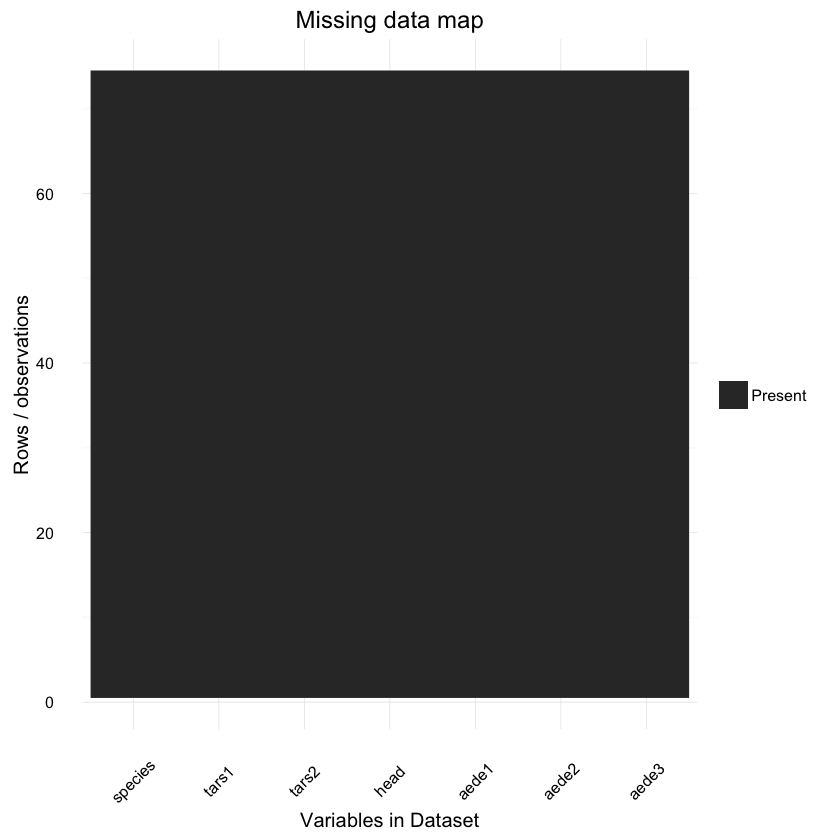

In [4]:
ggplot_missing(df)

How does the features in the dataset correlate to each other?

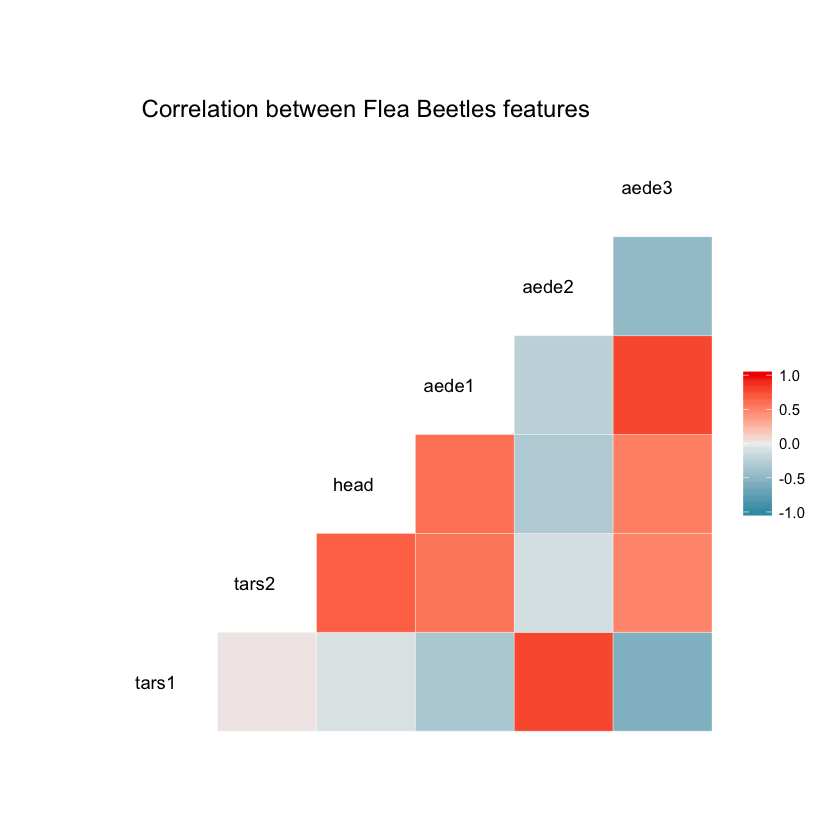

In [5]:
ggcorr(df, hjust = 0.8, layout.exp = 1) + 
    ggtitle("Correlation between Flea Beetles features")

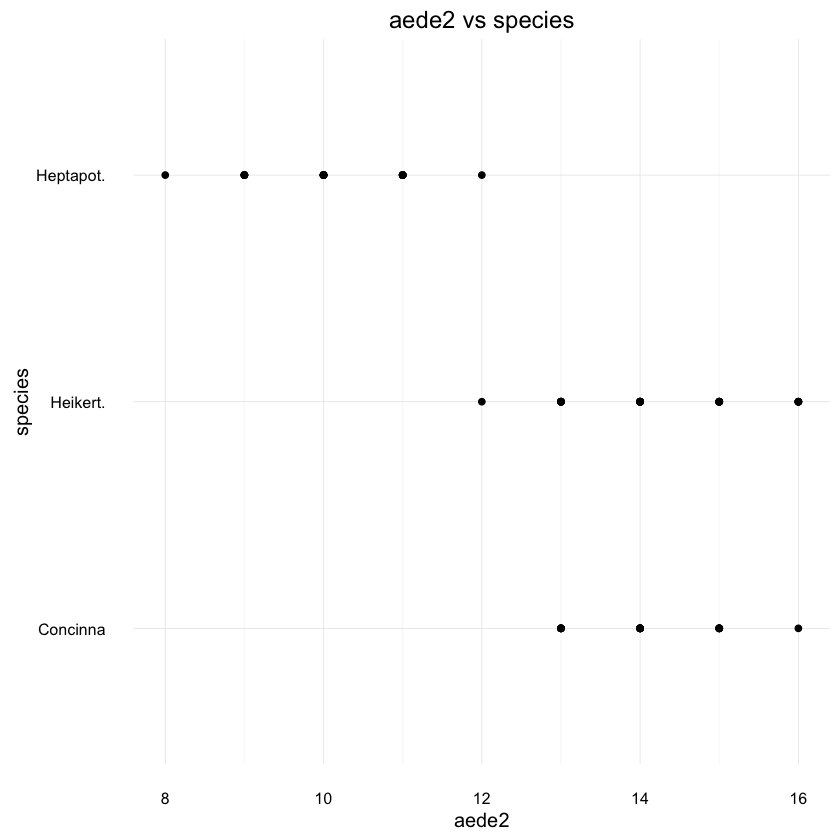

In [6]:
ggplot(df, aes(x = aede2, y = species)) + geom_point() + 
    ggtitle("aede2 vs species")

It looks like there is pretty good separation between Heptapot and the other 2 species based on `aede2` alone.

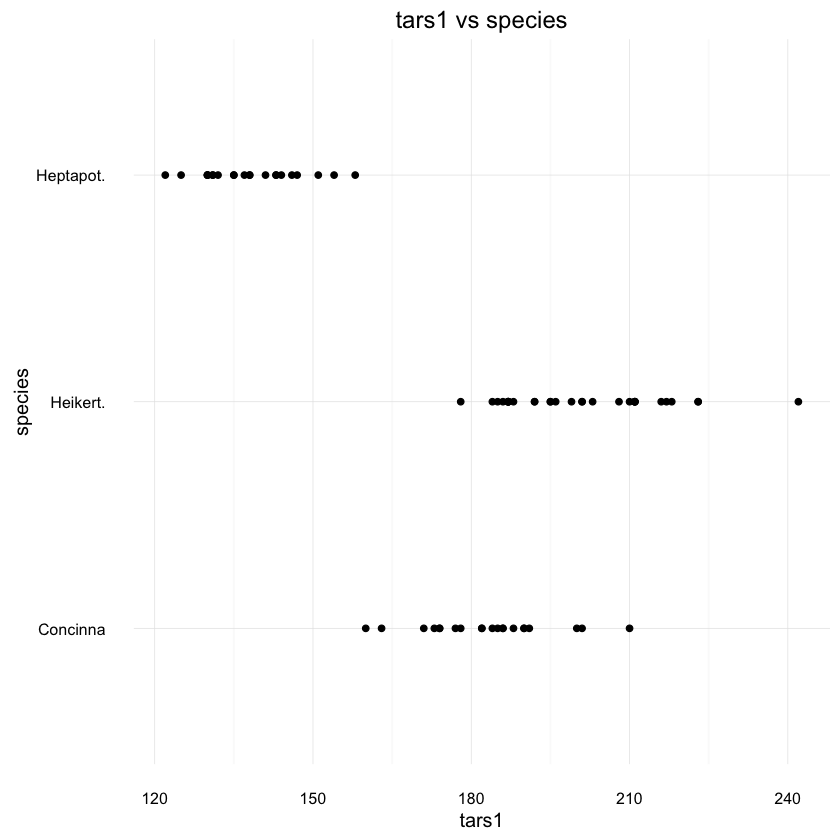

In [7]:
ggplot(df, aes(x = tars1, y = species)) + geom_point()  + 
    ggtitle("tars1 vs species")

`tars1` shows paints pretty similar picture. How about the species distribution in general?

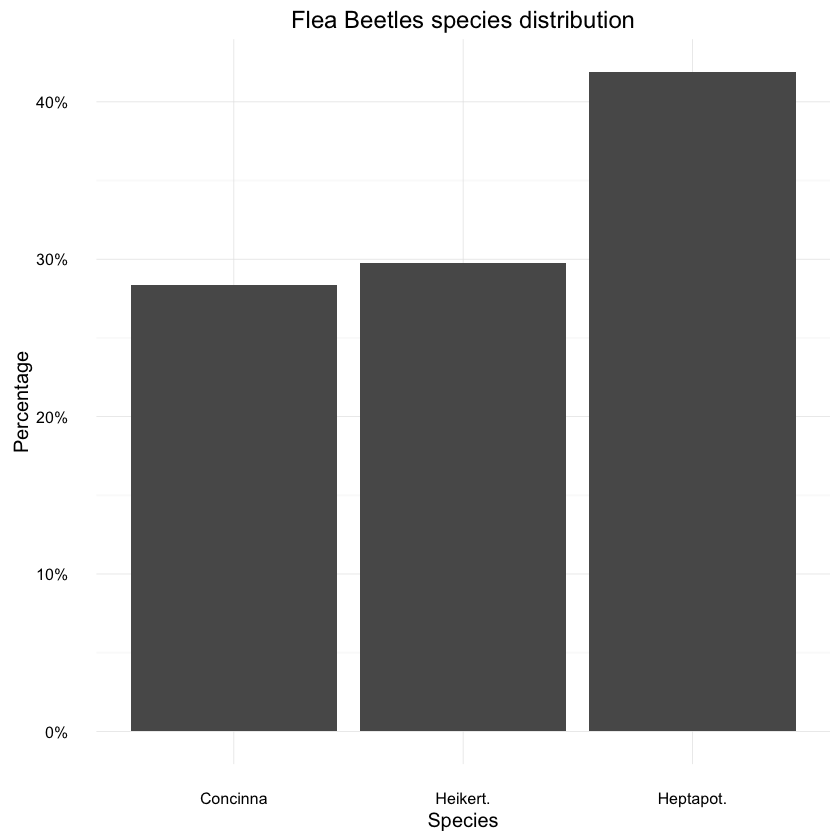

In [8]:
data <- as.data.frame(prop.table(table(df$species)))
colnames(data) <- c("Species", "Percentage")
data$Species <- unique(df$species)

ggplot(data=data, aes(x=Species, y=Percentage)) +
  geom_bar(position="dodge", stat="identity") + 
  ggtitle("Flea Beetles species distribution") +
  scale_y_continuous(labels=percent_format())

Looks ok, with lead to Heikert. Let's not forget that our dataset is pretty small though.

# Preprocessing

Now, let's shuffle and split our data into training and testing datasets. We'll convert the species into ints as well.

In [9]:
species <- levels(df$species)
df$species <- as.numeric(df$species)
df <- df[sample(nrow(df)),]

train_idx = createDataPartition(df$species, p=.8, list=FALSE)

In [10]:
train <- df[train_idx, ]
test <- df[-train_idx, ]

y_test <- df[-train_idx, ]$species

# Building our model

Now, let's get serious and put JAGS to a test. Here is a diagram of our model:

![](https://i.imgur.com/7beACOf.png)

You should try to understand that bottom to top. $y_i$ is what we are trying to ultimately predict. It is a categorical distribution. Then you move to the next level (up) where the softmax is defined and finally our normally distributed vague prior distributions.

Now for our model definition. It is defined in JAGS. Almost directly taken from Kruschke's book. So it is a string in R. First, we will standardize our input X for both training and testing data. Then, our $y_i$ is defined as categorical distribution (using `dcat`) that depends on our data and vague normally distributed priors.

We compute $y$ for our training and testing data within our JAGS model.

In [11]:
model_string = "
  # Standardize the data:
  data {
    for ( j in 1:n_features ) {
      xm[j]  <- mean(x[,j])
      xsd[j] <-   sd(x[,j])
      for ( i in 1:n ) {
        zx[i,j] <- ( x[i,j] - xm[j] ) / xsd[j]
      }
      # standardize the probe values:
      for ( i in 1:n_test ) {
        zx_test[i,j] <- (x_test[i,j] - xm[j] ) / xsd[j]
      }
    }
  }
  # Specify the model for standardized data:
  model {
    
    # Predicted y values at x_test:
    for ( i in 1:n_test ) {
      y_pred[i] ~ dcat( zy_pred[1:n_classes,i] ) # dcat normalizes its argument vector
      for ( r in 1:n_classes ) {
        zy_pred[r,i] <- exp( zbeta0[r] + sum( zbeta[r,1:n_features] * zx_test[i,1:n_features] ) ) 
      }
    }

    for ( i in 1:n ) {
      y[i] ~ dcat( explambda[1:n_classes,i] ) # dcat normalizes its argument vector
      for ( r in 1:n_classes ) {
        explambda[r,i] <- exp( zbeta0[r] + sum( zbeta[r,1:n_features] * zx[i,1:n_features] ) ) 
      }
    }
    # Priors vague on standardized scale:
    zbeta0[1] <- 0
    for ( j in 1:n_features ) { zbeta[1,j] <- 0 }
    for ( r in 2:n_classes ) { # notice starts at 2
      zbeta0[r] ~ dnorm( 0 , 1/20^2 )  
      for ( j in 1:n_features ) {
        zbeta[r,j] ~ dnorm( 0 , 1/20^2 )
      }
    }
    # Transform to original scale:
    for ( r in 1:n_classes ) {
      beta[r,1:n_features] <- zbeta[r,1:n_features] / xsd[1:n_features] 
      beta0[r] <- zbeta0[r] - sum( zbeta[r,1:n_features] * xm[1:n_features] / xsd[1:n_features] )
    }
  }
"

Let's glue up everything together using `runjags`.  

In [12]:
run_mcmc = function(x, y, x_test, model,
                    n_saved_steps=10000, 
                    thin_steps=1 ,
                    runjags_method , 
                    n_chains) {

  # Specify the data in a list, for later shipment to JAGS:
  data = list(
    x = x ,
    y = as.numeric(y) ,
    x_test = x_test ,
    n_test = nrow(x_test) ,
    n_features = dim(x)[2] ,
    n = dim(x)[1] ,
    n_classes = length(unique(y))
  )
    
  writeLines(model, con="TEMPmodel.txt" )
  #-----------------------------------------------------------------------------
  # RUN THE CHAINS
  parameters = c( "beta0" ,  "beta" ,  
                  "zbeta0" , "zbeta",
                  "x_test" , "y_pred")
    
  result <- run.jags( method=runjags_method ,
                          model="TEMPmodel.txt" , 
                          monitor=parameters , 
                          data=data ,
                          n.chains=n_chains ,
                          adapt=500 ,
                          burnin=1000 , 
                          silent.jags = TRUE,
                          sample=ceiling(n_saved_steps/n_chains) ,
                          thin=thin_steps,
                          summarise=FALSE ,
                          plots=FALSE)
  return(as.mcmc.list(result))
}

We create a list of features (flea beetles measures) who will be used for fitting the model and the species column which we want to predict.

In [13]:
n_cores = detectCores() 
if ( !is.finite(n_cores) ) { n_cores = 1 } 
if ( n_cores > 4 ) { 
  n_chains = 4  # because JAGS has only 4 rng's.
  runjags_method = "parallel"
}
if ( n_cores == 4 ) { 
  n_chains = 3  # save 1 core for other processes.
  runjags_method = "parallel"
}
if ( n_cores < 4 ) { 
  n_chains = 3 
  runjags_method = "rjags" # NOT parallel
}

Properly prepare our test data and finally do some simulations

In [14]:
features <- c("tars1", "tars2", "head", "aede1", "aede2", "aede3")

y = train[, "species"]
x = as.matrix(train[, features], ncol=length(x_features))

x_test <- matrix(unlist(test[, features]), nrow = nrow(test), byrow = TRUE)

samples = run_mcmc(x, y, x_test, model=model_string,
                    n_saved_steps=10000, 
                    thin_steps=5, 
                    runjags_method=runjags_method,
                    n_chains=n_chains)

Calling 4 simulations using the parallel method...
All chains have finished
Simulation complete.  Reading coda files...
Coda files loaded successfully
Finished running the simulation


# Some results

First, let's see if our model has found a fit? Here are the traceplots for the beta parametres (our priors) in our model. 

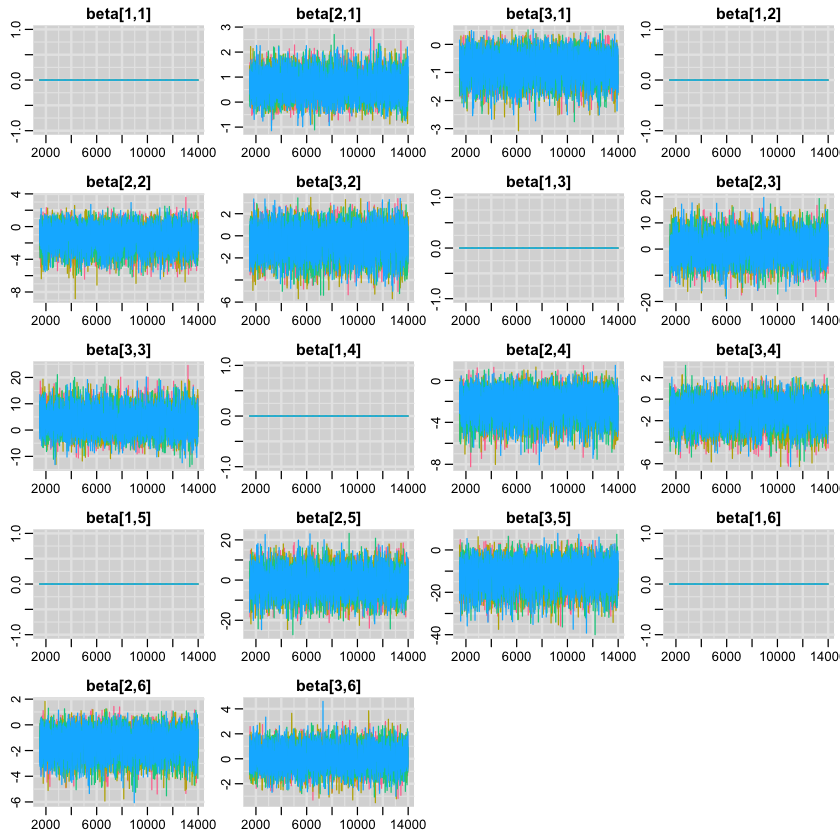

In [15]:
traplot(samples, "beta");

ERROR: Error in bw.SJ(x, method = "ste"): sample is too sparse to find TD


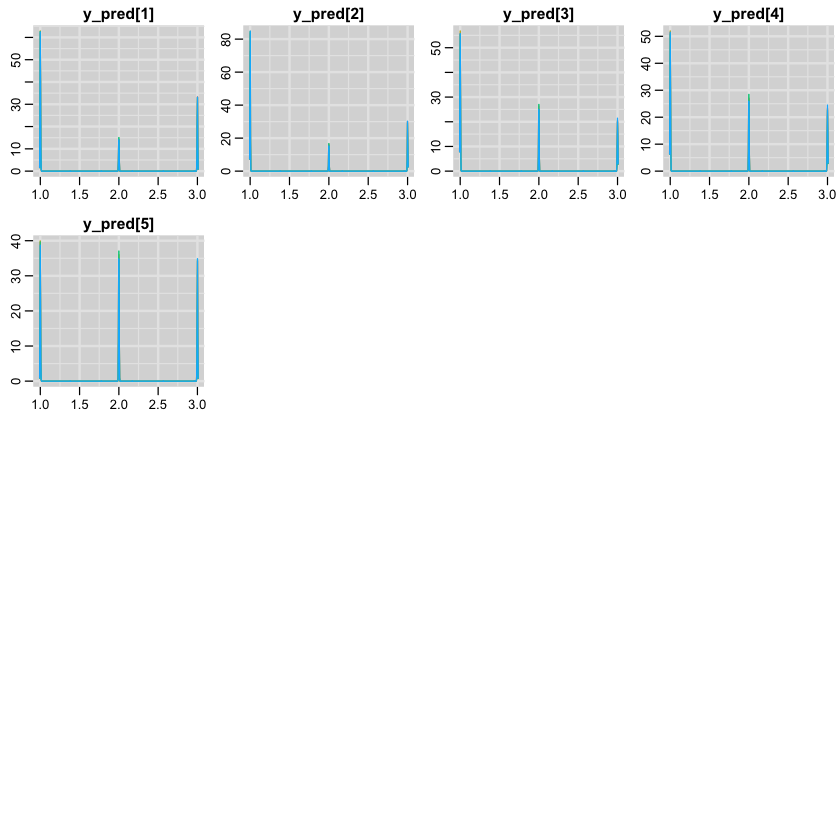

In [16]:
denplot(samples, "y_pred");

# Evaluation

So, is our model good? Short answer is - no. First, let's find all simulation results (columns in the result matrix) for our test data.

In [17]:
samples_mat = as.matrix(samples)
yp_cols = grep("y_pred", colnames(samples_mat) , value=FALSE )

And pick the most frequent value (MLE) in each column for our prediction.

In [18]:
max_cols <- c()
for(i in yp_cols) {
  max_cols <- c(max_cols, which.max(table(samples_mat[, i]))[[1]])
}

accuracy <- data.frame(predicted = max_cols, actual=as.numeric(y_test))

In [19]:
table(accuracy)

         actual
predicted 1 2 3
        1 2 4 2
        2 0 4 2

In [20]:
table(accuracy$predicted == accuracy$actual)


FALSE  TRUE 
    8     6 

Our accuracy is:

In [21]:
table(accuracy$predicted == accuracy$actual)[[2]] / nrow(accuracy)

[1] 0.4285714

That sounds pretty bad. Can you improve that with another model?

Let's have a look at a specific prediction. The main advantage of our Bayesian model is that it gives us a posterior distribution for each prediction. Think of it as a representation of uncertainty of the model's prediction.

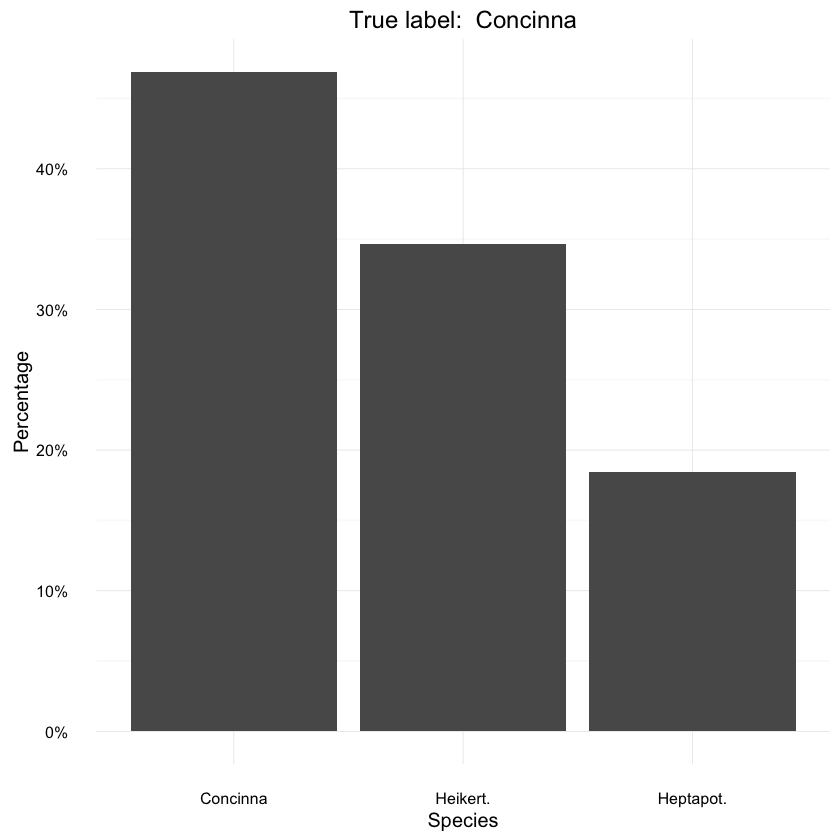

In [22]:
data <- as.data.frame(prop.table(table(samples_mat[, ncol(samples_mat) - 1])))
colnames(data) <- c("Species", "Percentage")
data$Species <- species

ggplot(data=data, aes(x=Species, y=Percentage)) +
  geom_bar(position="dodge", stat="identity") + 
  ggtitle(paste("True label: ", species[y_test[length(y_test) - 1]])) +
  scale_y_continuous(labels=percent_format())

# Conclusion

You made it! Well, kind of... Most probably you learned a lot, though.

Considering the size of our dataset (and that of our test data) it's pretty unclear how well we actually did. However, that uncertainty is directly baked into the model. You can predict and roughly know how wrong you might be no matter how small/big your data size is. That is truly powerful.

# References

[Doing Bayesian Data Analysis](https://sites.google.com/site/doingbayesiandataanalysis/what-s-new-in-2nd-ed) <br/>
[Diagnosing MCMC simulations](http://www.johnmyleswhite.com/notebook/2010/08/29/mcmc-diagnostics-in-r-with-the-coda-package/) <br/>
[POLS 506: Bayesian Statistics - great course on Bayesian Stats](http://jee3.web.rice.edu/teaching.htm) <br/>
[Frequentist example in R of Multinomial Logistic Regression](http://www.ats.ucla.edu/stat/r/dae/mlogit.htm) <br/>
[Bayesian Multiple Linear Regression Prediction in R](http://www4.stat.ncsu.edu/~reich/st590/code/Predict)